In [ ]:
from matplotlib import pyplot as plt
import xml.etree.ElementTree as ET
import os
from datetime import datetime

DATA_ROOT_DIR = "../../data"
DATA_DIR_AUTO = f"{DATA_ROOT_DIR}/final/transcripts/auto"
DATA_DIR_MANUAL = f"{DATA_ROOT_DIR}/final/transcripts/manual"
DATA_DIR_BEFORE_REVIEW = f"{DATA_ROOT_DIR}/final/transcripts/before_review"
DATA_DIR_ASR_VERSIONS = f"{DATA_ROOT_DIR}/final/asr_outputs"
PREFERENCE_ORDER = ['whisper', 'mixed', 'scratch']
SPEAKER_TYPES = ['exam', 'cand']

annotation2annot_duration = {}
annotation2duration = {}

def parse_xml_file(xml_file_path):

    tree = ET.parse(xml_file_path)

    root = tree.getroot()
    recording = None
    for r in root.iter('media'):
        recording = r.attrib['url']
        break
    assert recording is not None

    root = tree.getroot()
    annot_duration = -1
    for r in root.iter('annotDuration'):
        annot_duration =  r.text
        annot_duration = datetime.strptime(annot_duration, '%H:%M:%S').time()
        annot_duration = annot_duration.hour * 3600 + annot_duration.minute * 60
        break

    #TODO: this is a foo value
    duration = 0

    utterances = []
    last_end = -1
    for u in root.iter('u'):
        if u.text is not None and len(u.text) > 0:
            #if last_end > float(u.attrib['start']):
            #    print(f"Overlapping utterances in {xml_file_path}")
            last_end = float(u.attrib['end'])
            utterances.append({
                'start': float(u.attrib['start']),
                'end': float(u.attrib['end']),
                'text': u.text,
                'speaker': u.attrib['who'].lower(),
                'source': u.attrib['source'] if 'source' in u.attrib else None
            })
            duration += float(u.attrib['end']) - float(u.attrib['start'])
    annotation2duration[os.path.basename(xml_file_path)] = max(annotation2duration.get(recording, 0), duration)
    annotation2annot_duration[os.path.basename(xml_file_path)] = max(annotation2annot_duration.get(recording, 0), annot_duration)
    # print(xml_file_path, duration, annot_duration, len(utterances))
    return recording, utterances


def transcript_version_select(transcripts):
    for p in PREFERENCE_ORDER:
        for n, t in transcripts.items():
            if p in n:
                return t
    return next(iter(transcripts.values()))

def load_transcripts(data_dir):
    recordings = {}

    for xmlfile in os.listdir(data_dir):
        if xmlfile.endswith('.xml'):
            recording, utterances = parse_xml_file(os.path.join(data_dir, xmlfile))
            annotations = recordings.get(recording, {})
            annotations[xmlfile] = utterances
            recordings[recording] = annotations
    return recordings, {annot_name: annot for _, annotations in recordings.items() for annot_name, annot in annotations.items()}

manual_recordings, manual_annotations = load_transcripts(DATA_DIR_MANUAL)
auto_recordings, auto_annotations = load_transcripts(DATA_DIR_AUTO)
before_review_recordings, before_review_annotations = load_transcripts(DATA_DIR_BEFORE_REVIEW)

auto_recordings_versions = {}
for ver_name in os.listdir(DATA_DIR_ASR_VERSIONS):
    path = os.path.join(DATA_DIR_ASR_VERSIONS, ver_name)
    if os.path.isdir(path):
        recordings, annotations = load_transcripts(path)
        auto_recordings_versions[ver_name] = annotations

In [ ]:
import matplotlib.pyplot as plt

relevant = [
    #annotation2annot_duration[annot] for annot in manual_annotations.keys()
    annotation2annot_duration[annot] for annot in before_review_annotations.keys()
]

# Plotting the histogram
plt.hist(relevant, bins=100, edgecolor='black')

# Adding labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Displaying the histogram
plt.show()

# print annotations with duration more than 10000 seconds
for annot, duration in annotation2annot_duration.items():
    if duration > 10000:
        print(annot, duration)

In [ ]:
import matplotlib.pyplot as plt

relevant = [
    #annotation2annot_duration[annot] / annotation2duration[annot] for annot in manual_annotations.keys()
    annotation2annot_duration[annot] / annotation2duration[annot] for annot in before_review_annotations.keys()
]

# Plotting the histogram
plt.hist(relevant, bins=100, edgecolor='black')

# Adding labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Displaying the histogram
plt.show()

# print annotations with duration more than 10000 seconds
for annot in manual_annotations.keys():
    if annotation2annot_duration[annot] / annotation2duration[annot] > 30:
        print(annot, duration)

In [ ]:
data = []
for t in PREFERENCE_ORDER:
    relevant = [
        #annotation2annot_duration[annot] / annotation2duration[annot] for annot in manual_annotations.keys() if t in annot and 10000 > annotation2annot_duration[annot] > 0
        annotation2annot_duration[annot] / annotation2duration[annot] for annot in before_review_annotations.keys() if t in annot and 10000 > annotation2annot_duration[annot] > 0
    ]
    data.append([v for v in relevant if v < 1500])

# plot three histograms in 3D plot
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20, azim=250)
for i, d in enumerate(reversed(data)):
    hist, bins = np.histogram(d, bins=100)
    xs = (bins[:-1] + bins[1:]) / 2
    ax.bar(xs, hist, zs=i, zdir='y', alpha=0.8)

fig.legend(list(reversed(PREFERENCE_ORDER)))


In [ ]:
%load_ext autoreload
%autoreload 2

import uttalign

def sample_alignment():
    #key = list(before_review_annotations.keys())[0]
    key = "A2ML_221205_07-ET-from_mixed.xml"
    print(key)
    before_review_annotation = before_review_annotations[key]
    auto_annotation = auto_annotations[key]
    uttaligner = uttalign.MatrixAligner()

    alignment = uttaligner.align_utterances(before_review_annotation, auto_annotation)
    
    aligned_texts = [(uttalign.extract_text(i, before_review_annotation), uttalign.extract_text(j, auto_annotation)) for i, j in alignment]
    aligned_speakers = [(uttalign.extract_speaker(i, before_review_annotation), uttalign.extract_speaker(j, auto_annotation)) for i, j in alignment]

    print(aligned_texts)
    print(aligned_speakers)

    #print_alignment(alignments, before_review_annotation, auto_annotation)

sample_alignment()

## RQ1: Is manual post-editting of ASR outputs more eﬀicient than manual transcription?

### Measuring in edit distance (Levenshtein, LCS). For all transcripts.


In [ ]:
from collections import defaultdict

from Bio.pairwise2 import format_alignment

%load_ext autoreload
%autoreload 2
import uttalign
import utils

os.makedirs('alignments/rq1.1', exist_ok=True)

#annot2texts = {k: concat_texts_by_speaker(v) for k, v in before_review_annotations.items()}
before_review_auto_annot_pairs = {annot_name:(before_review_annotations[annot_name], auto_annotations[annot_name]) for annot_name in before_review_annotations}

annot2edit_distances = defaultdict(lambda: 0)
annot2numwords = defaultdict(lambda: 0)
edit_distances = defaultdict(lambda: 0)
totals = defaultdict(lambda: 0)

#aligner = uttalign.BioAligner()
aligner = uttalign.MatrixAligner(threshold_overlap=0.1)

for annot_name, (before_review_annot, auto_annot) in before_review_auto_annot_pairs.items():
    for transcript_type in PREFERENCE_ORDER:
        if transcript_type in annot_name:
            break

    utt_alignment = aligner.align_utterances(before_review_annot, auto_annot)

    aligned_texts = [(uttalign.extract_text(i, before_review_annot), uttalign.extract_text(j, auto_annot)) for i, j in utt_alignment]
    aligned_speakers = [(uttalign.extract_speaker(i, before_review_annot), uttalign.extract_speaker(j, auto_annot)) for i, j in utt_alignment]

    for (before_review_text, auto_text), (before_review_speaker, auto_speaker) in zip(aligned_texts, aligned_speakers):
        speaker_type = before_review_speaker
        if before_review_speaker is not None:
            for speaker_type in SPEAKER_TYPES:
                if speaker_type.lower() in before_review_speaker.lower():
                    break
        l = len(utils.normalize_text(before_review_text))
        #print(before_review_text, auto_text)
        agree, disagree, word_alignment = uttalign.align_texts(before_review_text, auto_text)
        # if l and disagree / l > 0.9:
        #     print(f"{annot_name} {before_review_speaker} {transcript_type} {agree} {disagree}")
        with open(f'alignments/rq1.1/{annot_name}_{before_review_speaker}.txt', 'w') as f:
            if word_alignment is not None:
                f.write(format_alignment(*word_alignment))
        if speaker_type:
            edit_distances[f"{transcript_type}:{speaker_type}"] += disagree
            totals[f"{transcript_type}:{speaker_type}"] += l
        edit_distances[transcript_type] += disagree
        totals[transcript_type] += l
        annot2edit_distances[annot_name] += disagree
        annot2numwords[annot_name] += l

print('Edit distances:     ', "\t".join([f"{k}:{v}" for k, v in edit_distances.items()]))
print('Total characters:   ', "\t".join([f"{k}:{v}" for k, v in totals.items()]))
print('Edits per character:', "\t".join([f"{k}:{v / totals[k]:.2f}" for k, v in edit_distances.items()]))

columns = ['whisper', 'mixed', 'scratch']
values = [totals[c] for c in columns]
relativ = [edit_distances[c] / totals[c] for c in columns]
fig, ax = plt.subplots()
ax.bar(columns, relativ)
ax.set_ylabel('Edit distance per word')


In [ ]:
from collections import defaultdict

from Bio.pairwise2 import format_alignment

%load_ext autoreload
%autoreload 2
import uttalign
import utils

os.makedirs('alignments/rq1.1chars', exist_ok=True)

#annot2texts = {k: concat_texts_by_speaker(v) for k, v in before_review_annotations.items()}
before_review_auto_annot_pairs = {annot_name:(before_review_annotations[annot_name], auto_annotations[annot_name]) for annot_name in before_review_annotations}

#aligner = uttalign.BioAligner()
aligner = uttalign.MatrixAligner(threshold_overlap=0.1)

edit_distances = defaultdict(lambda: 0)
totals = defaultdict(lambda: 0)
macro_avg_edit_distance = defaultdict(lambda: 0)
macro_avg_count  = defaultdict(lambda: 0)

for annot_name, (before_review_annot, auto_annot) in before_review_auto_annot_pairs.items():
    for transcript_type in PREFERENCE_ORDER:
        if transcript_type in annot_name:
            break
    
    utt_alignment = aligner.align_utterances(before_review_annot, auto_annot)

    aligned_texts = [(uttalign.extract_text(i, before_review_annot), uttalign.extract_text(j, auto_annot)) for i, j in utt_alignment]
    aligned_speakers = [(uttalign.extract_speaker(i, before_review_annot), uttalign.extract_speaker(j, auto_annot)) for i, j in utt_alignment]

    for (before_review_text, auto_text), (before_review_speaker, auto_speaker) in zip(aligned_texts, aligned_speakers):
        speaker_type = before_review_speaker
        if before_review_speaker is not None:
            for speaker_type in SPEAKER_TYPES:
                if speaker_type.lower() in before_review_speaker.lower():
                    break
        l = len(utils.normalize_text(before_review_text, char_level=True))
        #print(before_review_text, auto_text)
        agree, disagree, word_alignment = uttalign.align_texts(before_review_text, auto_text, char_level=True)
        # if l and disagree / l > 0.9:
        #     print(f"{annot_name} {before_review_speaker} {transcript_type} {agree} {disagree}")
        with open(f'alignments/rq1.1chars/{annot_name}_{before_review_speaker}.txt', 'w') as f:
            if word_alignment is not None:
                f.write(format_alignment(*word_alignment))
        if speaker_type:
            edit_distances[f"{transcript_type}:{speaker_type}"] += disagree
            totals[f"{transcript_type}:{speaker_type}"] += l
            macro_avg_edit_distance[f"{transcript_type}:{speaker_type}"] += disagree / l if l else 0
            macro_avg_count[f"{transcript_type}:{speaker_type}"] += 1
        edit_distances[transcript_type] += disagree
        totals[transcript_type] += l
        macro_avg_edit_distance[transcript_type] += disagree / l if l else 0
        macro_avg_count[transcript_type] += 1


print('Edit distances:     ', "\t".join([f"{k}:{v}" for k, v in edit_distances.items()]))
print('Total characters:   ', "\t".join([f"{k}:{v}" for k, v in totals.items()]))
print('Edits per character:', "\t".join([f"{k}:{v / totals[k]:.2f}" for k, v in edit_distances.items()]))
print('Edits per character (macro avg across utts):', "\t".join([f"{k}:{v / macro_avg_count[k]:.2f}" for k, v in macro_avg_edit_distance.items()]))

#columns = ['whisper', 'mixed', 'scratch']
columns = ['whisper', 'mixed']
values = [totals[c] for c in columns]
relativ = [edit_distances[c] / totals[c] for c in columns]
fig, ax = plt.subplots()
ax.bar(columns, relativ)
ax.set_ylabel('Edit distance per character')


## Comparison over all recordings. Duration per word, per second (of the recording). Average edit distance (in words, chars).

In [45]:
durations = defaultdict(lambda: 0)
annotdurations = defaultdict(lambda: 0)
edits = defaultdict(lambda: 0)
words = defaultdict(lambda: 0)

for annot_name in before_review_annotations.keys():
    for t in PREFERENCE_ORDER:
        if t in annot_name:
            break
    if -1 < annotation2annot_duration[annot_name] < 10000: #TODO: this is 
        durations[t] += annotation2duration[annot_name]
        annotdurations[t] += annotation2annot_duration[annot_name]
        edits[t] += annot2edit_distances[annot_name]
        words[t] += annot2numwords[annot_name]


print('Total times: ', durations)
print('Edit distances:', edits)
print('Annot to recording ratio:', [(k, annotdurations[k] / v) for k, v in durations.items()])
print('Annot time per word:', [(k, annotdurations[k] / v) for k, v in words.items()])
print('Annot duration per edit:', [(k, annotdurations[k] / v) for k, v in edits.items()])
print('Edit distance per word:', [(k, v / words[k]) for k, v in edits.items()])

Total times:  defaultdict(<function <lambda> at 0x7fbd6fed3ce0>, {'whisper': 8558.046, 'mixed': 15279.007000000001, 'scratch': 3136.0460000000007})
Edit distances: defaultdict(<function <lambda> at 0x7fbd939a3c40>, {'whisper': 2743, 'mixed': 8402, 'scratch': 4656})
Annot to recording ratio: [('whisper', 5.545658436516934), ('mixed', 8.984877093125226), ('scratch', 6.14149154699899)]
Annot time per word: [('whisper', 3.774155069582505), ('mixed', 6.417052306829337), ('scratch', 4.13659793814433)]
Annot duration per edit: [('whisper', 17.3022238425082), ('mixed', 16.338966912639847), ('scratch', 4.13659793814433)]
Edit distance per word: [('whisper', 0.21813121272365804), ('mixed', 0.3927452905155892), ('scratch', 1.0)]


### Comparison over the recordings that were both manually transcribed and manually post-edited. Total duration. Total edit distance.

In [46]:
relevant_recordings = [k for k, v in before_review_recordings.items() if any(['scratch' in a for a in v.keys()]) and len(v) > 1]

total_words = {}
total_duration = {}
total_edits = {}
total_annot_duration = {}

for recording in relevant_recordings:
    for annot_name in auto_recordings[recording]:
        for t in PREFERENCE_ORDER:
            if t in annot_name:
                break
        if t not in annot_name:
            continue
        if -1 < annotation2annot_duration[annot_name] < 10000: #TODO: this is 
            total_words[t] = total_words.get(t, 0) + annot2numwords[annot_name]
            total_duration[t] = total_duration.get(t, 0) + annotation2duration[annot_name]
            total_edits[t] = total_edits.get(t, 0) + annot2edit_distances[annot_name]
            total_annot_duration[t] = total_annot_duration.get(t, 0) + annotation2annot_duration[annot_name]

print('Relevant recordings:', len(relevant_recordings))
print('Total words: ', total_words)
print('Total duration:', total_duration)
print('Total edits:', total_edits)
print('Total annot duration:', total_annot_duration)
print('Edits per word:', [(k, total_edits[k] / v) for k, v in total_words.items()])
print('Duration per edit:', [(k, v / total_edits[k]) for k, v in total_duration.items()])
print('Annot duration per edit:', [(k, v / total_edits[k]) for k, v in total_annot_duration.items()])
print('Annot duration per word:', [(k, v / total_words[k]) for k, v in total_annot_duration.items()])

Relevant recordings: 4
Total words:  {'scratch': 3574, 'whisper': 3224, 'mixed': 1497}
Total duration: {'scratch': 2261.3070000000007, 'whisper': 2083.4060000000004, 'mixed': 831.3159999999999}
Total edits: {'scratch': 3574, 'whisper': 759, 'mixed': 561}
Total annot duration: {'scratch': 5340, 'whisper': 4740, 'mixed': 10020}
Edits per word: [('scratch', 1.0), ('whisper', 0.23542183622828783), ('mixed', 0.374749498997996)]
Duration per edit: [('scratch', 0.632710408505876), ('whisper', 2.7449354413702247), ('mixed', 1.4818467023172903)]
Annot duration per edit: [('scratch', 1.494124230554001), ('whisper', 6.24505928853755), ('mixed', 17.86096256684492)]
Annot duration per word: [('scratch', 1.494124230554001), ('whisper', 1.4702233250620347), ('mixed', 6.693386773547094)]


### Do the duration and edit distance correlate?
TODO

### Is there a significant difference across annotators? Some might prefer one way of transcribing over the other.


In [47]:
def parse_annotator(annot_name):
    n = annot_name.split('from')[0]
    n = n[:-1].split('-')[-1]
    assert len(n) > 0   
    return n

total_words = {}
total_duration = {}
total_edits = {}
total_annot_duration = {}

annotators = set([parse_annotator(a) for a in auto_annotations.keys()])



for recording in manual_recordings.keys():
    for annot_name in manual_recordings[recording]:
        for t in PREFERENCE_ORDER:
            if t in annot_name:
                break
        if t not in annot_name:
            continue

        if -1 < annotation2annot_duration[annot_name] < 10000: #TODO: this is 
            annotator = parse_annotator(annot_name)
            total_words[f'{t}_{annotator}'] = total_words.get(f'{t}_{annotator}', 0) + annot2numwords[annot_name]
            total_duration[f'{t}_{annotator}'] = total_duration.get(f'{t}_{annotator}', 0) + annotation2duration[annot_name]
            total_edits[f'{t}_{annotator}'] = total_edits.get(f'{t}_{annotator}', 0) + annot2edit_distances[annot_name]
            total_annot_duration[f'{t}_{annotator}'] = total_annot_duration.get(f'{t}_{annotator}', 0) + annotation2annot_duration[annot_name]

print('Annotators:', annotators)
# print('Total words: ', total_words)
# print('Total duration:', total_duration)
# print('Total edits:', total_edits)
# print('Total annot duration:', total_annot_duration)
print('Edits per word:', sorted([(k, total_edits[k] / v) for k, v in total_words.items()], key=lambda x: x[0]))
print()
print('Annot duration per word:', sorted([(k, total_annot_duration[k] / v) for k, v in total_words.items()], key=lambda x: x[0]))
print()
# print('Duration per edit:', [(k, v / total_edits[k]) for k, v in total_duration.items()])
print('Annot duration per edit:', sorted([(k, v / total_edits[k]) for k, v in total_annot_duration.items()], key=lambda x: x[0]))


Annotators: {'AP', 'ZM', 'KR', 'MH', 'MR', 'KV', 'LR', 'ET'}
Edits per word: [('mixed_AP', 0.39020452099031216), ('mixed_ET', 0.4446828803051979), ('mixed_KV', 0.34038398958672306), ('mixed_LR', 0.4293116210214656), ('mixed_MH', 0.33199651264167396), ('mixed_ZM', 0.4279475982532751), ('scratch_ET', 1.0), ('scratch_KR', 1.0), ('scratch_MR', 1.0), ('scratch_ZM', 1.0), ('whisper_AP', 0.23098591549295774), ('whisper_ET', 0.28029197080291973), ('whisper_KV', 0.21444797819173103), ('whisper_LR', 0.17688679245283018), ('whisper_MH', 0.1709247117341171), ('whisper_ZM', 0.26753093694755453)]

Annot duration per word: [('mixed_AP', 13.659849300322929), ('mixed_ET', 8.340486409155938), ('mixed_KV', 5.642694435405142), ('mixed_LR', 11.946706143597336), ('mixed_MH', 0.0), ('mixed_ZM', 8.440424204616344), ('scratch_ET', 6.7114093959731544), ('scratch_KR', 0.0), ('scratch_MR', 0.0), ('scratch_ZM', 4.32532347504621), ('whisper_AP', 8.822535211267606), ('whisper_ET', 5.781021897810219), ('whisper_KV', 

Text(0.5, 1.0, 'Annotaton duration per word')

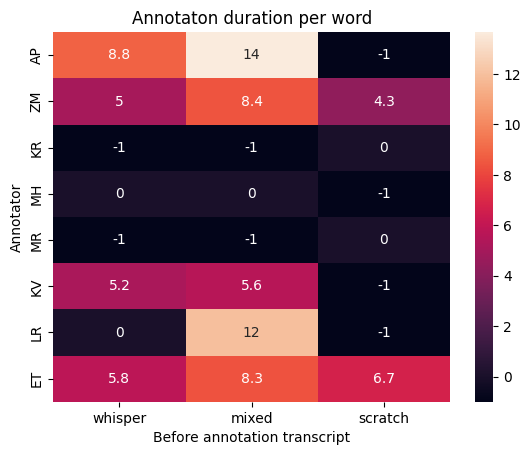

In [48]:

columns = ['whisper', 'mixed', 'scratch']
rows = list(annotators)
values = {k: total_annot_duration[k] / v for k, v in total_words.items()}
# plot a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.heatmap([[values.get(f'{c}_{r}', -1) for c in columns] for r in rows], annot=True, ax=ax, xticklabels=columns, yticklabels=rows)
ax.set_xlabel('Before annotation transcript')
ax.set_ylabel('Annotator')
ax.set_title('Annotaton duration per word')


Text(0.5, 1.0, 'Annotator duration per recording duration')

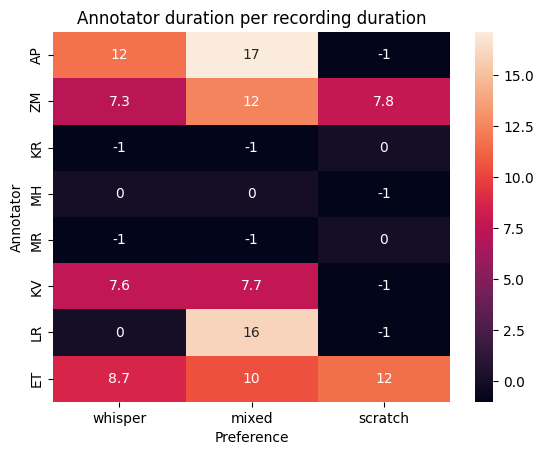

In [49]:
columns = ['whisper', 'mixed', 'scratch']
rows = list(annotators)
values = {k: total_annot_duration[k] / v for k, v in total_duration.items()}
# plot a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.heatmap([[values.get(f'{c}_{r}', -1) for c in columns] for r in rows], annot=True, ax=ax, xticklabels=columns, yticklabels=rows)
ax.set_xlabel('Preference')
ax.set_ylabel('Annotator')
ax.set_title('Annotator duration per recording duration')


### Is there a significant difference across exercise types?

In [ ]:
# TODO

## Align AUTO to MANUAL on utterance level

Idea: concat per speaker texts -> align AUTO to MANUAL -> resegment MANUAL based on the alignment and AUTO segmentation

In [ ]:
#TODO: do we need this cell?

def concat_texts_by_speaker_with_source(utterances):
    texts = {}
    for u in utterances:
        words = texts.get(u['speaker'], [])
        words.extend([
            (w, u['source']) for w in normalize_text(u['text'])
        ])
        texts[u['speaker']] = words
    return texts

def match_fn(a, b):
    a, b = set(a), set(b)
    return len(a.intersection(b)) / len(a.union(b))

relevant_annotation_names = [k for k, v in before_review_annotations.items() if 'mixed' in k]
for annot_name in relevant_annotation_names[1:]:
    before_review_texts = concat_texts_by_speaker_with_source(before_review_annotations[annot_name])
    auto_texts = concat_texts_by_speaker_with_source(auto_annotations[annot_name])

    for speaker in auto_texts.keys():
        if speaker not in before_review_texts:
            print(f"Speaker {speaker} not found in before review texts for {annot_name}")
            continue
        before_review_text = before_review_texts[speaker]
        auto_text = auto_texts[speaker]
        singletons = pairwise2.align.globalcs(auto_text, before_review_text, one_alignment_only=True, gap_char=[(None, None)], open=0, extend=0,
                                                  match_fn=lambda a, b: 1 if a[0] == b[0] else 0)
        print(f"Alignment for {annot_name} {speaker} with score {singletons[0][2]}")
        curr_auto_text, curr_br_text, curr_source = [], [], None
        for (auto_text, src), (br_text, _) in zip(singletons[0][0], singletons[0][1]):
            if curr_source == None:
                curr_source = src

            if src != None and curr_source != src:
                # if annot_name == 'A2ML_220919_01-KV-from_mixed.xml':
                #     # print(f"Current source: {curr_source}")
                #     # print(f"Auto: {' '.join(curr_auto_text)}")
                #     # print(f"BR:   {' '.join(curr_br_text)}")
                #     # print()
                curr_auto_text, curr_br_text, curr_source = [], [], src

            curr_auto_text += [auto_text] if auto_text != None else ''
            curr_br_text += [br_text] if br_text != None else ''
    #     break
    # break
            

## 

# RQ4: Is the human post-edited transcription biased towards the ASR system it was based on?
## measure WER or other ASR metrics on outputs of multiple ASR systems while varying the reference transcripts

In [50]:
def parse_annot_type(filename):
    return filename.split('from_')[-1].split('.')[0]

aligner = uttalign.MatrixAligner(threshold_overlap=0.1)

wers = {}
for reference_asr, version in auto_recordings_versions.items():
    agree, disagree = defaultdict(lambda: 0), defaultdict(lambda: 0)
    for recname, asr_transcript in version.items():
        recname = recname.replace('.xml', '.mp3')
        # asr_transcript = sort_by_time(asr_transcript)
        
        if recname not in manual_recordings:
            continue
            
        for annot_name, manual_transcript in manual_recordings[recname].items():
            annot_type = parse_annot_type(annot_name)

            utt_alignment = aligner.align_utterances(manual_transcript, asr_transcript)

            aligned_texts = [(uttalign.extract_text(i, manual_transcript), uttalign.extract_text(j, asr_transcript)) for i, j in utt_alignment]
            for manual_text, asr_text in aligned_texts:
                a, d, _ = uttalign.align_texts(asr_text, manual_text)
                agree[annot_type] += a
                disagree[annot_type] += d

    print(f"ASR version {reference_asr}:")
    for annot_type in agree.keys():
        print(f"  {annot_type}: {agree[annot_type]} / {disagree[annot_type]}; WER: {disagree[annot_type] / (agree[annot_type] + disagree[annot_type])}")
        wers[f'{reference_asr}_{annot_type}'] = disagree[annot_type] / (agree[annot_type] + disagree[annot_type])


ASR version mms-1b-all:
  whisperX: 6383 / 6843; WER: 0.5173899894147891
  mixed: 9342 / 11359; WER: 0.5487174532631274
  scratch: 1239 / 2660; WER: 0.6822262118491921
ASR version mms-1b-fl102:
  mixed: 11264 / 9630; WER: 0.4608978654159089
  scratch: 1535 / 2563; WER: 0.625427037579307
  whisperX: 7466 / 5853; WER: 0.4394474059614085
ASR version whisperX-large-v2:
  mixed: 15297 / 5720; WER: 0.272160631869439
  whisperX: 10429 / 2948; WER: 0.22037826119458773
  scratch: 2215 / 2177; WER: 0.49567395264116576
ASR version whisper-large-v3:
  mixed: 13944 / 7905; WER: 0.36180145544418507
  whisperX: 9290 / 4640; WER: 0.3330940416367552
  scratch: 1963 / 2420; WER: 0.5521332420716404


{'mms-1b-all_whisperX': 0.5173899894147891, 'mms-1b-all_mixed': 0.5487174532631274, 'mms-1b-all_scratch': 0.6822262118491921, 'mms-1b-fl102_mixed': 0.4608978654159089, 'mms-1b-fl102_scratch': 0.625427037579307, 'mms-1b-fl102_whisperX': 0.4394474059614085, 'whisperX-large-v2_mixed': 0.272160631869439, 'whisperX-large-v2_whisperX': 0.22037826119458773, 'whisperX-large-v2_scratch': 0.49567395264116576, 'whisper-large-v3_mixed': 0.36180145544418507, 'whisper-large-v3_whisperX': 0.3330940416367552, 'whisper-large-v3_scratch': 0.5521332420716404}


Text(0.5, 1.0, 'Word error rate')

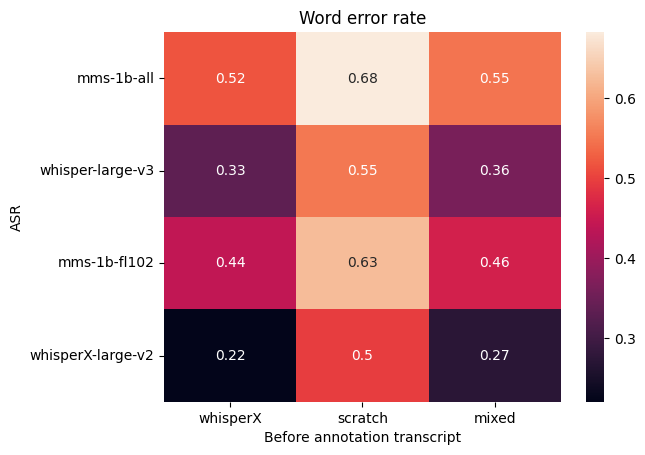

In [51]:
# plot a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

print(wers)
fig, ax = plt.subplots()
columns = set(c.split('_')[1] for c in wers.keys())
rows = set(c.split('_')[0] for c in wers.keys())
sns.heatmap([[wers.get(f'{r}_{c}', -1) for c in columns] for r in rows], annot=True, ax=ax, xticklabels=columns, yticklabels=rows)
ax.set_xlabel('Before annotation transcript')
ax.set_ylabel('ASR')
ax.set_title('Word error rate')

# Auto to Manual Utterances alignment

In [ ]:
%load_ext autoreload
%autoreload 2
import uttalign

os.makedirs('alignment_test', exist_ok=True)

matrix_aligner = uttalign.MatrixAligner(threshold_overlap=0.05)
bio_aligner = uttalign.BioAligner()

for annot_file, manual_annotation in manual_annotations.items():
    if annot_file != "A2ML_221205_15-ZM-from_mixed.xml":
        continue
    print(f"Processing {annot_file}")
    auto_annotation = auto_annotations[annot_file]
    if not len(auto_annotation):
        continue
    matrix_alignment = matrix_aligner.align_utterances(manual_annotation, auto_annotation)
    with open(f'alignment_test/{annot_file}_matrix.txt', 'w') as f:
        for a, b in matrix_alignment:
            a_text = uttalign.extract_text(a, manual_annotation)
            b_text = uttalign.extract_text(b, auto_annotation)
            print(f"MANUAL: {a_text}", file=f)
            print(f"AUTO: {b_text}", file=f)
            print(file=f)

    bio_alignment = bio_aligner.align_utterances(manual_annotation, auto_annotation)
    with open(f'alignment_test/{annot_file}_bio.txt', 'w') as f:
        for a, b in bio_alignment:
            a_text = uttalign.extract_text(a, manual_annotation)
            b_text = uttalign.extract_text(b, auto_annotation)
            print(f"MANUAL: {a_text}", file=f)
            print(f"AUTO: {b_text}", file=f)
            print(file=f)

""" with open('alignments.txt', 'w') as f:
    for reference_asr, version in auto_recordings_versions.items():
        for recname, asr_transcript in version.items():
            recname = recname.replace('.xml', '.mp3')
            
            if recname not in manual_recordings:
                continue
                
            f.write(f"ASR version {reference_asr} for {recname}:\n")
            for annot_name, manual_transcript in manual_recordings[recname].items():

                alignment = align_utterances(manual_transcript,asr_transcript, )
                for idx, (a, b) in enumerate(zip(alignment[0][0], alignment[0][1])):
                    if b is not None:
                        al = []
                        if a is None:
                            a = find_best_alignment_for_auto(alignment[0], idx)
                        if a is not None:
                            al.extend(a['original_utterances'])
                        # print(b['original_utterances'])
                        f.write(f"{b['original_utterances']} -> {al}\n")
        #         break
        #     break
        # break
 """

## Notes
 - Using WhisperX segmentation biases the number of utterances (e.g., 07-npi-test-B1.mp3 with 161 and 273)

## Basic Stats

In [52]:
# TODO: how to compute the total duration?
total_duration = sum(list(recording.values())[0][-1]['end'] - list(recording.values())[0][0]['start'] for recording in recordings.values())
print(f"Total recordings:  {len(recordings)}")
print(f"Total duration:    {total_duration:.02f} seconds ({total_duration/60:.02f} minutes)")

# TODO: should we take the max or select some specific version?
total_utterances = sum(max(len(utterances) for utterances in transcripts.values()) for transcripts in recordings.values())
print(f"Total utterances:  {total_utterances}")

total_words = sum(
    max(
        sum(
            len(utterance['text'].split())
            for utterance in transcript
        )
        for transcript in recording.values()
    )
 for recording in recordings.values())
print(f"Total words:       {total_words}")


num_versions_histogram = {}
for recording, transcripts in recordings.items():
    num_versions = len(transcripts)
    num_versions_histogram[num_versions] = num_versions_histogram.get(num_versions, 0) + 1
print(f"Version histogram: {num_versions_histogram}")

num_speakers_histogram = {}
for recording, transcripts in recordings.items():
    num_speakers = max(len(set([u['speaker'] for u in utterances])) for utterances in transcripts.values())
    num_speakers_histogram[num_speakers] = num_speakers_histogram.get(num_speakers, 0) + 1
print(f"Speaker histogram: {num_speakers_histogram}")


Total recordings:  58
Total duration:    27815.18 seconds (463.59 minutes)
Total utterances:  5497
Total words:       33499
Version histogram: {1: 58}
Speaker histogram: {2: 48, 3: 6, 5: 1, 1: 3}


## Students Stats

In [ ]:
total_student_duration = sum(
    max(
        sum(
            utterance['end'] - utterance['start']
            for utterance in transcript
            if utterance['speaker'] != 't'
        )
        for transcript in recording.values()
    )
 for recording in recordings.values())
print(f"Total student duration:    {total_student_duration:.02f} seconds ({total_student_duration/60:.02f} minutes); {total_student_duration/total_duration*100:.02f}% of total duration")

total_student_utterances = sum(
    max(
        sum(
            utterance['speaker'] != 't'
            for utterance in transcript
        )
        for transcript in recording.values()
    )
 for recording in recordings.values())
print(f"Total student utterances:  {total_student_utterances} ({total_student_utterances/total_utterances*100:.02f}% of total utterances)")

total_student_words = sum(
    max(
        sum(
            len(utterance['text'].split())
            for utterance in transcript
            if utterance['speaker'] != 't'
        )
        for transcript in recording.values()
    )
 for recording in recordings.values())
print(f"Total student words:       {total_student_words} ({total_student_words/total_words*100:.02f}% of total words)")

## Level Stats

In [ ]:
for level in ['A1', 'A2', 'B1', 'B2', 'C1']:
    relevant = [transcript_version_select(r) for n, r in recordings.items() if level in n]
    
    duration = sum(transcript[-1]['end'] - transcript[0]['start'] for transcript in relevant)
    print(f'{level}: {len(relevant)} recordings; {duration:.02f} seconds ({duration/60:.02f} minutes)')

    

## Inter-annotator Agreement

Recording A2ML_230724_29_anonym_audio.mp3
  A2ML_230724_29-KV-from_whisperX.xml vs A2ML_230724_29-ZM-from_whisperX.xml (student cand_1):	 73.51% agreement	 297 agree, 107 disagree
  A2ML_230724_29-KV-from_whisperX.xml vs A2ML_230724_29-ZM-from_whisperX.xml (student exam_1):	 96.62% agreement	 971 agree, 34 disagree
  A2ML_230724_29-KV-from_whisperX.xml vs A2ML_230724_29-ET-from_mixed.xml (student cand_1):	 72.86% agreement	 306 agree, 114 disagree
  A2ML_230724_29-KV-from_whisperX.xml vs A2ML_230724_29-ET-from_mixed.xml (student exam_1):	 95.60% agreement	 977 agree, 45 disagree
  A2ML_230724_29-ZM-from_whisperX.xml vs A2ML_230724_29-ET-from_mixed.xml (student cand_1):	 73.58% agreement	 312 agree, 112 disagree
  A2ML_230724_29-ZM-from_whisperX.xml vs A2ML_230724_29-ET-from_mixed.xml (student exam_1):	 94.17% agreement	 969 agree, 60 disagree
Recording 12-npi-test-A2.mp3
  12-npi-test-A2-MH_from_whisperX.xml vs 12-npi-test-A2-MR_from_scratch.xml (student exam_1):	 1.84% agreement	 34 a

Text(50.722222222222214, 0.5, 'Hypothesis')

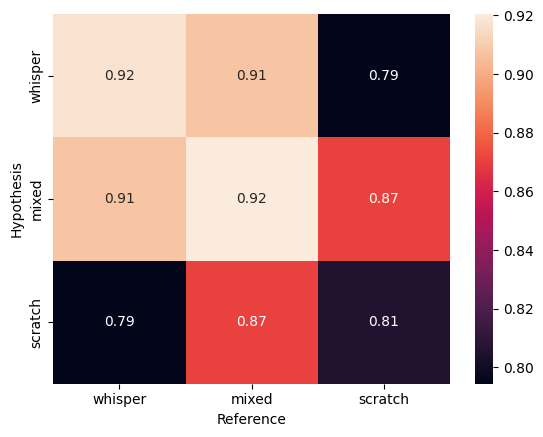

In [53]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from mosestokenizer import MosesTokenizer, MosesPunctuationNormalizer

if not os.path.exists('alignments'):
    os.makedirs('alignments')

punct_normalizer = MosesPunctuationNormalizer('cs')
tokenizer = MosesTokenizer('cs')

def normalize_text(text):
    text = text.lower().replace('\n', " ")
    text = punct_normalizer(text)
    text = tokenizer(text)
    return [t for t in text if t.isalnum()]

def align_texts_w(text1, text2):
    text1 = normalize_text(text1)
    text2 = normalize_text(text2)
    alignments = pairwise2.align.globalxs(text1, text2, one_alignment_only=True, gap_char=['-'], open=-1, extend=-1)
    
    agree, disagree = 0, 0
    for a, b in zip(alignments[0][0], alignments[0][1]):
        if a == b:
            agree += 1
        else:
            disagree += 1
    return agree, disagree, alignments[0]

def align_texts(text1, text2):
    text1 = list("".join(normalize_text(text1)))
    text2 = list("".join(normalize_text(text2)))
    alignments = pairwise2.align.globalxs(text1, text2, one_alignment_only=True, open=-1, extend=-1, gap_char=['-'])
    
    agree, disagree = 0, 0
    for a, b in zip(alignments[0][0], alignments[0][1]):
        if a == b:
            agree += 1
        else:
            disagree += 1
    return agree, disagree, alignments[0]

def concat_texts_by_speaker(utterances):
    speakers = set([u['speaker'] for u in utterances])
    texts = {}
    for speaker in speakers:
        texts[speaker] = ' '.join([u['text'] for u in utterances if u['speaker'] == speaker])
    return speakers, texts

relevant = {n: r for n, r in before_review_recordings.items() if len(r) > 1}

def get_type(name):
    if 'whisper' in name:
        return 'whisper'
    if 'mixed' in name:
        return 'mixed'
    if 'scratch' in name:
        return 'scratch'
    return 'unknown'

agreements = {}
disagreements = {}

for name, transcripts in relevant.items():
    print(f"Recording {name}")
    for idx, (n1, t1) in enumerate(list(transcripts.items())):
        speakers, t1 = concat_texts_by_speaker(t1)
        for n2, t2 in list(transcripts.items())[idx+1:]:
            speakers, t2 = concat_texts_by_speaker(t2)
            for speaker in speakers:
                if speaker not in t1 or speaker not in t2:
                    continue
                agree, disagree, alignment = align_texts(t1[speaker], t2[speaker])
                
                speaker = 'teacher' if speaker == 't' else 'student ' + speaker
                print(f"  {n1} vs {n2} ({speaker}):\t {agree/(agree+disagree)*100:.02f}% agreement\t {agree} agree, {disagree} disagree")
                if agree / (agree + disagree) < 0.25:
                    continue
                agreements[get_type(n1), get_type(n2)] = agreements.get((get_type(n1), get_type(n2)), 0) + agree
                disagreements[get_type(n1), get_type(n2)] = disagreements.get((get_type(n1), get_type(n2)), 0) + disagree
                
                agreements[get_type(n2), get_type(n1)] = agreements[get_type(n1), get_type(n2)]
                disagreements[get_type(n2), get_type(n1)] = disagreements[get_type(n1), get_type(n2)]

                with open(f'alignments/{name}_{n1}_{n2}_{speaker}.txt', 'w') as f:
                    f.write(format_alignment(*alignment))
                    f.write(f"\n{agree/(agree+disagree)*100:.02f}% agreement\t {agree} agree, {disagree} disagree\n")



print(agreements)
print(disagreements)
print({k: v / (disagreements[k] + v) for k, v in agreements.items()})

# plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.heatmap([[agreements.get((r, c), 0) / (disagreements.get((r, c), 0) + agreements.get((r, c), 1)) for c in ['whisper', 'mixed', 'scratch']] for r in ['whisper', 'mixed', 'scratch']], annot=True, ax=ax, xticklabels=['whisper', 'mixed', 'scratch'], yticklabels=['whisper', 'mixed', 'scratch'])
ax.set_xlabel('Reference')
ax.set_ylabel('Hypothesis')


Recording A2ML_230724_29_anonym_audio.mp3
  A2ML_230724_29-KV-from_whisperX.xml vs A2ML_230724_29-ZM-from_whisperX.xml :	 77.64% agreement	 316 agree, 91 disagree
Speaker mismatch: cand_1 vs exam_1
Děkuji XXX.
--------------------
Děkuji moc. Na shledanou.

  A2ML_230724_29-KV-from_whisperX.xml vs A2ML_230724_29-ET-from_mixed.xml :	 77.00% agreement	 318 agree, 95 disagree
Speaker mismatch: cand_1 vs exam_1
Děkuji ***
--------------------
Děkuji moc. Na shledanou.

  A2ML_230724_29-ZM-from_whisperX.xml vs A2ML_230724_29-ET-from_mixed.xml :	 78.87% agreement	 336 agree, 90 disagree
Recording 12-npi-test-A2.mp3
Speaker mismatch: exam_1 vs cand_1
Děkuji. Teď budeme dělat úkol číslo 1. Budete odpovídat na 10 otázek. Vaše téma je roční období a odpovídejte prosím celou větou.
--------------------
Dobře. Jsem z Ruska. hm Dobře. Květen. *** zkoušim někam na výlet. hm Sněžilo, byla i zima. Teď teplo. Takové počasí. O Vánocích jsem byl v práci. Kdy víc prší? Víc. Víc prší asi na ***

Speaker mi

Text(50.722222222222214, 0.5, 'Hypothesis')

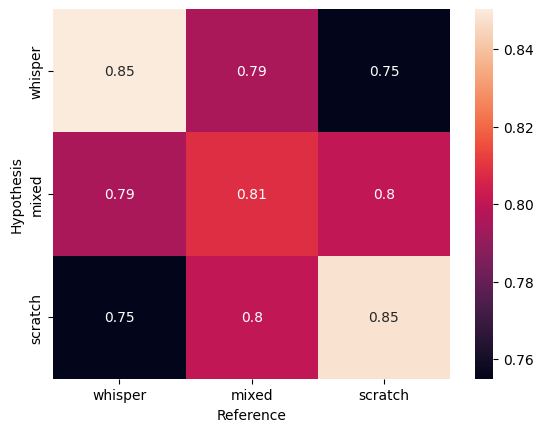

In [64]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
from mosestokenizer import MosesTokenizer, MosesPunctuationNormalizer

if not os.path.exists('alignments'):
    os.makedirs('alignments')

punct_normalizer = MosesPunctuationNormalizer('cs')
tokenizer = MosesTokenizer('cs')

def normalize_text(text):
    text = text.lower().replace('\n', " ")
    text = punct_normalizer(text)
    text = tokenizer(text)
    return [t for t in text if t.isalnum()]

def align_texts_w(text1, text2):
    text1 = normalize_text(text1)
    text2 = normalize_text(text2)
    alignments = pairwise2.align.globalxs(text1, text2, one_alignment_only=True, gap_char=['-'], open=-1, extend=-1)
    
    agree, disagree = 0, 0
    for a, b in zip(alignments[0][0], alignments[0][1]):
        if a == b:
            agree += 1
        else:
            disagree += 1
    return agree, disagree, alignments[0]

def align_texts(text1, text2):
    text1 = list("".join(normalize_text(text1)))
    text2 = list("".join(normalize_text(text2)))
    alignments = pairwise2.align.globalxs(text1, text2, one_alignment_only=True, open=-1, extend=-1, gap_char=['-'])
    
    agree, disagree = 0, 0
    for a, b in zip(alignments[0][0], alignments[0][1]):
        if a == b:
            agree += 1
        else:
            disagree += 1
    return agree, disagree, alignments[0]


relevant = {n: r for n, r in before_review_recordings.items() if len(r) > 1}

def get_type(name):
    if 'whisper' in name:
        return 'whisper'
    if 'mixed' in name:
        return 'mixed'
    if 'scratch' in name:
        return 'scratch'
    return 'unknown'

agreements = defaultdict(lambda: 0)
disagreements = defaultdict(lambda: 0)
num_recordings = defaultdict(lambda: 0)

aligner = uttalign.BioAligner()

for name, transcripts in relevant.items():
    transcripts = list(transcripts.items())
    print(f"Recording {name}")
    for idx, (annotation_name1, transcript1) in enumerate(transcripts):
        for annotation_name2, transcript2 in transcripts[idx+1:]:
            alignment = aligner.align_utterances(transcript1, transcript2, both_manual=True)
            aligned_texts = [(uttalign.extract_text(i, transcript1), uttalign.extract_text(j, transcript2)) for i, j in alignment]
            aligned_speakers = [(uttalign.extract_speaker(i, transcript1), uttalign.extract_speaker(j, transcript2)) for i, j in alignment]

            annot_agree, annot_disagree = 0, 0   
            for (t1, t2), (s1, s2) in zip(aligned_texts, aligned_speakers):
                agree, disagree, _ = uttalign.align_texts(t1, t2)
                if s1 != s2 and len(t1) > 0 and len(t2) > 0:
                    print(f"Speaker mismatch: {s1} vs {s2}")
                    print(t1)
                    print('-'*20)
                    print(t2)
                    print("="*20)
                    print()
                t1 = get_type(annotation_name1)
                t2 = get_type(annotation_name2)


                
                
                annot_agree += agree
                annot_disagree += disagree
              
            print(f"  {annotation_name1} vs {annotation_name2} :\t {annot_agree / (annot_agree + annot_disagree)*100:.02f}% agreement\t {annot_agree} agree, {annot_disagree} disagree")
            if annot_agree / (annot_agree + annot_disagree) < 0.6:  
                continue
                
            agreements[t1, t2] += annot_agree
            disagreements[t1, t2] += annot_disagree
            agreements[t2, t1] = agreements[t1, t2]
            disagreements[t2, t1] = disagreements[t1, t2]
            num_recordings[t1, t2] += 1
            num_recordings[t2, t1] = num_recordings[t1, t2]

            # for speaker in speakers:
            #     if speaker not in t1 or speaker not in t2:
            #         continue
            #     agree, disagree, alignment = align_texts(t1[speaker], t2[speaker])
                
            #     speaker = 'teacher' if speaker == 't' else 'student ' + speaker
            #     print(f"  {n1} vs {n2} ({speaker}):\t {agree/(agree+disagree)*100:.02f}% agreement\t {agree} agree, {disagree} disagree")
            #     if agree / (agree + disagree) < 0.25:
            #         continue
            #     agreements[get_type(n1), get_type(n2)] = agreements.get((get_type(n1), get_type(n2)), 0) + agree
            #     disagreements[get_type(n1), get_type(n2)] = disagreements.get((get_type(n1), get_type(n2)), 0) + disagree
                
            #     agreements[get_type(n2), get_type(n1)] = agreements[get_type(n1), get_type(n2)]
            #     disagreements[get_type(n2), get_type(n1)] = disagreements[get_type(n1), get_type(n2)]

            #     with open(f'alignments/{name}_{n1}_{n2}_{speaker}.txt', 'w') as f:
            #         f.write(format_alignment(*alignment))
            #         f.write(f"\n{agree/(agree+disagree)*100:.02f}% agreement\t {agree} agree, {disagree} disagree\n")



print(agreements)
print(disagreements)
print({k: v / (disagreements[k] + v) for k, v in agreements.items()})

# plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.heatmap([[agreements.get((r, c), 0) / (disagreements.get((r, c), 0) + agreements.get((r, c), 1)) for c in ['whisper', 'mixed', 'scratch']] for r in ['whisper', 'mixed', 'scratch']], annot=True, ax=ax, xticklabels=['whisper', 'mixed', 'scratch'], yticklabels=['whisper', 'mixed', 'scratch'])
ax.set_xlabel('Reference')
ax.set_ylabel('Hypothesis')


Text(50.722222222222214, 0.5, 'Hypothesis')

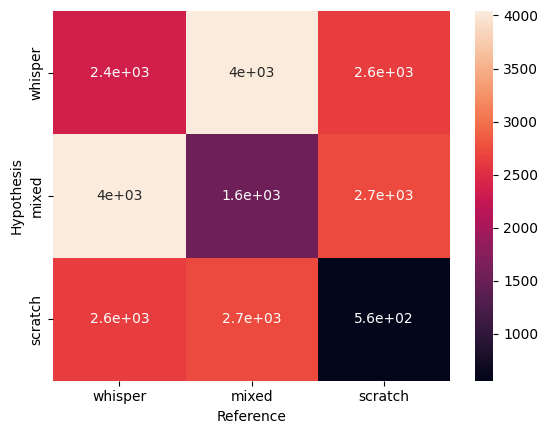

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.heatmap([[(disagreements.get((r, c), 0) + agreements.get((r, c), 1)) for c in ['whisper', 'mixed', 'scratch']] for r in ['whisper', 'mixed', 'scratch']], annot=True, ax=ax, xticklabels=['whisper', 'mixed', 'scratch'], yticklabels=['whisper', 'mixed', 'scratch'])
ax.set_xlabel('Reference')
ax.set_ylabel('Hypothesis')
